# Optimized XGBoost Model - Feature-Reduced Version
## Based on Feature Importance Analysis

**Objective**: Improve XGBoost model by removing low-importance features

**Strategy**:
- Remove clustering features (0% importance)
- Remove low-value seasonality features
- Remove low-value trend features
- Focus on top-performing features

**Expected Outcome**: Simpler model with similar or better performance

In [ ]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost openpyxl -q

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('default')
sns.set_palette('husl')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [2]:

print("="*80)
print("LOADING DATA")
print("="*80)

# Load the Excel file
df = pd.read_excel('soya_data_cleaned_2023_onwards.xlsx')

print(f"Original dataset loaded: {df.shape[0]} records, {df.shape[1]} columns")
print(f"\nColumns: {df.columns.tolist()}")

LOADING DATA
Original dataset loaded: 15297 records, 25 columns

Columns: ['expedition_number', 'client_order_number', 'product_name', 'client_name', 'postal_code_client', 'city_client', 'country_client', 'sales_order_creation_date', 'promised_expedition_date', 'actual_expedition_date', 'date_and_time_expedition', 'contract_number', '\ntotal_ordered_converted', 'total_amount_ordered_tm', 'total_amount_delivered_tm', 'city_of_delivery', 'inventory_tag', 'inventory_location', 'total_ordered_converted', 'purchasing_order_number', 'trucking_company_name', 'bill_number', 'cost_of_purchased_order', 'quantity_of_purchase_order', 'year']


In [3]:
print(f"Dataset shape before combining batches: {df.shape}")
print(f"Date range: {df['actual_expedition_date'].min()} to {df['actual_expedition_date'].max()}")

# Combine orders with same client_order_number (delivered in batches)
print(f"\nTotal records before combining batches: {len(df)}")
print(f"Unique client_order_numbers: {df['client_order_number'].nunique()}")

# Check for duplicates
duplicates = df['client_order_number'].duplicated().sum()
print(f"Orders delivered in multiple batches: {duplicates}")

# Group by client_order_number and aggregate:
# - actual_expedition_date: take the LAST date (max) - when final batch was delivered
# - total_amount_delivered_tm: SUM all batches
# - other fields: take first (they should be the same for the same order)
agg_dict = {
    'sales_order_creation_date': 'first',
    'actual_expedition_date': 'max',  # Last delivery date
    'total_amount_delivered_tm': 'sum',  # Sum all batches
    'client_name': 'first',
}

# Add any other columns that exist in the dataframe
for col in df.columns:
    if col not in agg_dict and col != 'client_order_number':
        agg_dict[col] = 'first'

df = df.groupby('client_order_number', as_index=False).agg(agg_dict)

print(f"After combining batches: {len(df)} unique orders")
print()

df.head()

Dataset shape before combining batches: (15297, 25)
Date range: 2023-01-04 15:37:01 to 2025-09-16 00:00:00

Total records before combining batches: 15297
Unique client_order_numbers: 6887
Orders delivered in multiple batches: 8410
After combining batches: 6887 unique orders



,client_order_number,sales_order_creation_date,actual_expedition_date,total_amount_delivered_tm,client_name,expedition_number,product_name,postal_code_client,city_client,country_client,promised_expedition_date,date_and_time_expedition,contract_number,\ntotal_ordered_converted,total_amount_ordered_tm,city_of_delivery,inventory_tag,inventory_location,total_ordered_converted,purchasing_order_number,trucking_company_name,bill_number,cost_of_purchased_order,quantity_of_purchase_order,year
0,SO-11118,2023-01-03,2023-01-04 15:37:01,2.26,MEUNERIE MARIO BERARD INC,231352.0,Huile de Soya,J0E 1E0,ANGE-GARDIEN,canada,2023-01-03,NaT,None,NaN,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
1,SO-11119,2023-01-03,2023-01-05 09:16:47,5.07,FERME QUIKO INC,231353.0,Trituro Laitier - Régulier,J0J 1Y0,SAINT-IGNACE-DE-STANBRIDGE,canada,2023-01-05,NaT,None,NaN,5.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
2,SO-11120,2023-01-03,2023-01-06 12:03:53,7.72,LES MOULEES BELLIFRANCE,231356.0,Trituro Laitier - Régulier,J2R 1E9,SAINT-HYACINTHE,canada,2023-01-06,NaT,None,NaN,3.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
3,SO-11121,2023-01-03,2023-01-05 07:39:39,3.15,SOLLIO AGRICULTURE S.E.C.,231355.0,Trituro Laitier - Régulier,G6E 0L9,Sainte-Marie,canada,2023-01-05,NaT,None,NaN,3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
4,SO-11122,2023-01-03,2023-01-05 16:21:49,1.80,MACEWEN AGRICENTRE INC,231357.0,Huile de Soya,K0C 1T0,MAXVILLE,canada,2023-01-04,NaT,None,NaN,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023


## Data Preprocessing
Replicate the preprocessing steps from the main notebook

In [4]:
# Date conversions
date_columns = ['sales_order_creation_date', 'promised_expedition_date', 
                'actual_expedition_date', 'date_and_time_expedition']

for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

print("✅ Date columns converted")

✅ Date columns converted


In [5]:
# Order size categorization
df['order_size_category'] = pd.cut(
    df['total_amount_delivered_tm'],
    bins=[0, 1, 5, 10, float('inf')],
    labels=['Small', 'Medium', 'Large', 'Extra Large']
)

# Filter for Small/Medium orders only
df_filtered = df[df['order_size_category'].isin(['Small', 'Medium'])].copy()

print(f"Filtered dataset: {df_filtered.shape[0]} records")
print(f"\nCategory breakdown:")
print(df_filtered['order_size_category'].value_counts())

Filtered dataset: 1285 records

Category breakdown:
order_size_category
Medium         1108
Small           177
Large             0
Extra Large       0
Name: count, dtype: int64


In [6]:
# Sort by client and date
df_filtered = df_filtered.sort_values(['client_name', 'sales_order_creation_date'])

# Calculate days since last order
df_filtered['days_since_last_order'] = df_filtered.groupby('client_name')['sales_order_creation_date'].diff().dt.days

# Calculate next order date and days until next order
df_filtered['next_order_date'] = df_filtered.groupby('client_name')['sales_order_creation_date'].shift(-1)
df_filtered['days_until_next_order'] = (df_filtered['next_order_date'] - df_filtered['sales_order_creation_date']).dt.days

# Cap at 30 days
df_filtered['days_until_next_order'] = df_filtered['days_until_next_order'].clip(upper=30)

print("✅ Temporal features created")

✅ Temporal features created


## Feature Engineering
Create only the high-importance features based on the analysis

In [7]:
# Temporal features
df_filtered['order_month'] = df_filtered['sales_order_creation_date'].dt.month
df_filtered['order_quarter'] = df_filtered['sales_order_creation_date'].dt.quarter
df_filtered['order_day_of_week'] = df_filtered['sales_order_creation_date'].dt.dayofweek
df_filtered['order_day_of_month'] = df_filtered['sales_order_creation_date'].dt.day
df_filtered['is_weekend'] = (df_filtered['order_day_of_week'] >= 5).astype(int)

# Cyclical encoding
df_filtered['month_sin'] = np.sin(2 * np.pi * df_filtered['order_month'] / 12)
df_filtered['month_cos'] = np.cos(2 * np.pi * df_filtered['order_month'] / 12)
df_filtered['day_of_week_sin'] = np.sin(2 * np.pi * df_filtered['order_day_of_week'] / 7)
df_filtered['day_of_week_cos'] = np.cos(2 * np.pi * df_filtered['order_day_of_week'] / 7)

# Season
df_filtered['season'] = df_filtered['order_month'].map({
    12: 0, 1: 0, 2: 0,  # Winter
    3: 1, 4: 1, 5: 1,   # Spring
    6: 2, 7: 2, 8: 2,   # Summer
    9: 3, 10: 3, 11: 3  # Fall
})

# Special dates (kept minimal based on low seasonality importance)
df_filtered['is_month_end'] = (df_filtered['order_day_of_month'] >= 28).astype(int)
df_filtered['is_quarter_end'] = df_filtered['order_month'].isin([3, 6, 9, 12]).astype(int)
df_filtered['is_near_holiday'] = df_filtered['order_month'].isin([12, 1]).astype(int)

print("✅ Temporal features created")

✅ Temporal features created


In [8]:
# Product features
le_product = LabelEncoder()
df_filtered['product_encoded'] = le_product.fit_transform(df_filtered['product_name'].fillna('Unknown'))

# Product-client interaction
product_client_stats = df_filtered.groupby(['client_name', 'product_name']).agg({
    'total_amount_delivered_tm': ['count', 'mean']
}).reset_index()
product_client_stats.columns = ['client_name', 'product_name', 'product_client_frequency', 'product_client_avg_quantity']
df_filtered = df_filtered.merge(product_client_stats, on=['client_name', 'product_name'], how='left')

# Product switching
df_filtered['product_switched'] = (df_filtered.groupby('client_name')['product_name'].shift(1) != df_filtered['product_name']).astype(int)

# Product popularity
product_popularity = df_filtered.groupby('product_name').size()
df_filtered['product_popularity_score'] = df_filtered['product_name'].map(product_popularity).fillna(0)

# Client product diversity
client_product_diversity = df_filtered.groupby('client_name')['product_name'].nunique()
df_filtered['client_product_diversity'] = df_filtered['client_name'].map(client_product_diversity)

print("✅ Product features created")

✅ Product features created


In [9]:
# Order sequence
df_filtered['order_sequence'] = df_filtered.groupby('client_name').cumcount() + 1

# Rolling window features (high importance)
for window in [3, 5, 7]:
    df_filtered[f'rolling_avg_days_{window}'] = df_filtered.groupby('client_name')['days_since_last_order'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )
    df_filtered[f'rolling_std_days_{window}'] = df_filtered.groupby('client_name')['days_since_last_order'].transform(
        lambda x: x.rolling(window=window, min_periods=1).std()
    ).fillna(0)

# Rolling quantity features (only 3 and 5 day windows based on importance)
for window in [3, 5]:
    df_filtered[f'rolling_avg_quantity_{window}'] = df_filtered.groupby('client_name')['total_amount_delivered_tm'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )
    df_filtered[f'rolling_std_quantity_{window}'] = df_filtered.groupby('client_name')['total_amount_delivered_tm'].transform(
        lambda x: x.rolling(window=window, min_periods=1).std()
    ).fillna(0)

print("✅ Rolling window features created")

✅ Rolling window features created


In [10]:
# Expanding window features
df_filtered['days_since_last_order_expanding_mean'] = df_filtered.groupby('client_name')['days_since_last_order'].transform(
    lambda x: x.expanding(min_periods=1).mean()
)
df_filtered['days_since_last_order_expanding_std'] = df_filtered.groupby('client_name')['days_since_last_order'].transform(
    lambda x: x.expanding(min_periods=1).std()
).fillna(0)

df_filtered['quantity_expanding_mean'] = df_filtered.groupby('client_name')['total_amount_delivered_tm'].transform(
    lambda x: x.expanding(min_periods=1).mean()
)
df_filtered['quantity_expanding_std'] = df_filtered.groupby('client_name')['total_amount_delivered_tm'].transform(
    lambda x: x.expanding(min_periods=1).std()
).fillna(0)

print("✅ Expanding window features created")

✅ Expanding window features created


In [11]:
# Trend features (keeping only high-importance ones)
df_filtered['order_frequency_trend'] = df_filtered.groupby('client_name')['days_since_last_order'].transform(
    lambda x: x.diff().fillna(0)
)
df_filtered['quantity_trend'] = df_filtered.groupby('client_name')['total_amount_delivered_tm'].transform(
    lambda x: x.diff().fillna(0)
)

# Recent vs historical comparison
df_filtered['recent_vs_historical_frequency'] = (
    df_filtered['rolling_avg_days_3'] / (df_filtered['days_since_last_order_expanding_mean'] + 1)
)
df_filtered['recent_vs_historical_quantity'] = (
    df_filtered['rolling_avg_quantity_3'] / (df_filtered['quantity_expanding_mean'] + 1)
)
df_filtered['is_frequency_increasing'] = (
    df_filtered['rolling_avg_days_3'] < df_filtered['days_since_last_order_expanding_mean']
).astype(int)

print("✅ Trend features created")

✅ Trend features created


In [12]:
# Recency features
latest_date = df_filtered['sales_order_creation_date'].max()
df_filtered['recency_days'] = (latest_date - df_filtered['sales_order_creation_date']).dt.days
df_filtered['days_since_last_order_filled'] = df_filtered.groupby('client_name')['days_since_last_order'].transform(
    lambda x: x.fillna(method='ffill').fillna(0)
)
df_filtered['days_deviation_from_mean'] = (
    df_filtered['days_since_last_order_filled'] - df_filtered['days_since_last_order_expanding_mean']
)
df_filtered['is_overdue_order'] = (
    df_filtered['days_deviation_from_mean'] > df_filtered['days_since_last_order_expanding_std']
).astype(int)

# Client lifetime at order time
df_filtered['days_since_first_order'] = df_filtered.groupby('client_name')['sales_order_creation_date'].transform(
    lambda x: (x - x.min()).dt.days
)
df_filtered['client_order_count_at_time'] = df_filtered.groupby('client_name').cumcount() + 1
df_filtered['client_lifetime_at_order'] = df_filtered['days_since_first_order']
df_filtered['order_frequency_at_time'] = df_filtered['client_order_count_at_time'] / (df_filtered['client_lifetime_at_order'] + 1)

print("✅ Recency and client lifetime features created")

✅ Recency and client lifetime features created


## Client-Level Features (HIGH IMPORTANCE)
Focus on client history and volume-based features

In [13]:
# Client-level aggregations
client_features = df_filtered.groupby('client_name').agg({
    'total_amount_delivered_tm': ['mean', 'std', 'min', 'max', 'count', 'sum'],
    'days_since_last_order': ['mean', 'std', 'median', 'min', 'max'],
    'sales_order_creation_date': ['min', 'max']
}).reset_index()

client_features.columns = ['_'.join(col).strip('_') for col in client_features.columns.values]
client_features.rename(columns={'client_name': 'client_name'}, inplace=True)

# Volume-based features (HIGH IMPORTANCE)
client_features['total_volume_tonnes'] = client_features['total_amount_delivered_tm_sum']
client_features['client_lifetime_days'] = (
    client_features['sales_order_creation_date_max'] - client_features['sales_order_creation_date_min']
).dt.days
client_features['avg_volume_per_order'] = (
    client_features['total_volume_tonnes'] / client_features['total_amount_delivered_tm_count']
)
client_features['volume_per_day'] = (
    client_features['total_volume_tonnes'] / (client_features['client_lifetime_days'] + 1)
)
client_features['order_frequency_per_month'] = (
    client_features['total_amount_delivered_tm_count'] / ((client_features['client_lifetime_days'] + 1) / 30)
)
client_features['predicted_annual_volume'] = client_features['volume_per_day'] * 365
client_features['client_volume_tier'] = pd.qcut(
    client_features['total_volume_tonnes'],
    q=5,
    labels=[0, 1, 2, 3, 4],
    duplicates='drop'
).astype(float).fillna(2)

# Consistency features (HIGH IMPORTANCE)
client_features['ordering_consistency_score'] = (
    client_features['days_since_last_order_mean'] / (client_features['days_since_last_order_std'] + 1)
)
client_features['order_size_consistency'] = (
    client_features['total_amount_delivered_tm_mean'] / (client_features['total_amount_delivered_tm_std'] + 1)
)

# Client maturity
client_features['client_maturity'] = pd.cut(
    client_features['total_amount_delivered_tm_count'],
    bins=[0, 5, 15, 30, np.inf],
    labels=[0, 1, 2, 3]
).astype(int)

# High frequency flag
median_freq = client_features['order_frequency_per_month'].median()
client_features['is_high_frequency_client'] = (
    client_features['order_frequency_per_month'] > median_freq
).astype(int)

print(f"✅ Client-level features created: {len(client_features.columns)} features")
print(f"   Total clients: {len(client_features)}")

✅ Client-level features created: 25 features
   Total clients: 131


In [14]:
# Merge client features
df_features = df_filtered.merge(client_features, on='client_name', how='left')

print(f"Dataset shape after merging: {df_features.shape}")
print(f"Columns: {df_features.columns.tolist()}")

Dataset shape after merging: (1285, 100)
Columns: ['client_order_number', 'sales_order_creation_date', 'actual_expedition_date', 'total_amount_delivered_tm', 'client_name', 'expedition_number', 'product_name', 'postal_code_client', 'city_client', 'country_client', 'promised_expedition_date', 'date_and_time_expedition', 'contract_number', '\ntotal_ordered_converted', 'total_amount_ordered_tm', 'city_of_delivery', 'inventory_tag', 'inventory_location', 'total_ordered_converted', 'purchasing_order_number', 'trucking_company_name', 'bill_number', 'cost_of_purchased_order', 'quantity_of_purchase_order', 'year', 'order_size_category', 'days_since_last_order', 'next_order_date', 'days_until_next_order', 'order_month', 'order_quarter', 'order_day_of_week', 'order_day_of_month', 'is_weekend', 'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos', 'season', 'is_month_end', 'is_quarter_end', 'is_near_holiday', 'product_encoded', 'product_client_frequency', 'product_client_avg_quantity', 

In [15]:
# Remove rows without next order (can't train on these)
df_model = df_features[df_features['days_until_next_order'].notna()].copy()

print(f"Modeling dataset size: {len(df_model)} records")
print(f"\nTarget variable (days_until_next_order) statistics:")
print(df_model['days_until_next_order'].describe())

Modeling dataset size: 1154 records

Target variable (days_until_next_order) statistics:
count    1154.000000
mean       14.744367
std        12.017247
min         0.000000
25%         3.000000
50%        13.000000
75%        30.000000
max        30.000000
Name: days_until_next_order, dtype: float64


## OPTIMIZED FEATURE SELECTION
### Removing Low-Importance Features

**Features REMOVED** (based on importance analysis):
- ❌ All clustering features (0% importance): `client_cluster`, `cluster_avg_frequency`, `cluster_avg_volume`, `cluster_avg_reorder_days`
- ❌ Low-value seasonality: Keeping only critical temporal features
- ❌ Rolling quantity 7-day window (low importance)

**Total features**: ~40 (down from 62)

In [16]:
print("="*80)
print("OPTIMIZED FEATURE SELECTION - FOCUS ON HIGH-IMPORTANCE FEATURES")
print("="*80)

# Select only high-importance features
optimized_features = [
    # ========================================================================
    # CORE TEMPORAL FEATURES (Top category: 31.22% importance)
    # ========================================================================
    'days_since_last_order',
    'days_since_last_order_mean',              # 19.02% - HIGHEST IMPORTANCE
    'days_since_last_order_std',
    'days_since_last_order_expanding_mean',
    'days_since_last_order_expanding_std',
    
    # ========================================================================
    # ROLLING WINDOW FEATURES (15.81% importance)
    # ========================================================================
    'rolling_avg_days_3',
    'rolling_std_days_3',
    'rolling_avg_days_5',                      # 3.41% importance
    'rolling_std_days_5',
    'rolling_avg_days_7',                      # 3.60% importance - highest rolling window
    'rolling_std_days_7',
    'rolling_avg_quantity_3',
    'rolling_std_quantity_3',
    'rolling_avg_quantity_5',                  # 1.38% importance
    'rolling_std_quantity_5',                  # 1.38% importance
    # NOTE: Removed rolling_avg_quantity_7 and rolling_std_quantity_7 (low importance)
    
    # ========================================================================
    # CUSTOMER VOLUME FEATURES (25.82% importance - 2nd highest category)
    # ========================================================================
    'total_volume_tonnes',                     # 7.45% importance - 3rd overall
    'volume_per_day',                          # 4.10% importance
    'avg_volume_per_order',
    'predicted_annual_volume',                 # 2.51% importance
    'client_volume_tier',
    'order_frequency_per_month',               # 8.82% importance - 2nd overall
    'order_frequency_at_time',                 # 2.08% importance
    
    # ========================================================================
    # CLIENT BEHAVIORAL FEATURES (Part of 31.22% category)
    # ========================================================================
    'client_lifetime_days',
    'ordering_consistency_score',              # 6.21% importance - 4th overall
    'order_size_consistency',
    'client_maturity',
    'is_high_frequency_client',
    
    # ========================================================================
    # RECENT ORDER PATTERNS (5.11% importance)
    # ========================================================================
    'recency_days',
    'days_deviation_from_mean',
    'is_overdue_order',
    'days_since_first_order',                  # 1.28% importance
    'client_order_count_at_time',              # 1.29% importance
    
    # ========================================================================
    # TREND & MOMENTUM (3.66% importance - keeping for diversity)
    # ========================================================================
    'order_frequency_trend',
    'quantity_trend',
    'recent_vs_historical_frequency',
    'recent_vs_historical_quantity',
    'is_frequency_increasing',
    
    # ========================================================================
    # PRODUCT INTERACTIONS (11.05% importance)
    # ========================================================================
    'product_encoded',                         # 1.32% importance
    'product_client_frequency',
    'product_client_avg_quantity',             # 1.37% importance
    'product_switched',                        # 3.54% importance - 7th overall
    'product_popularity_score',
    'client_product_diversity',                # 2.99% importance
    
    # ========================================================================
    # ORDER CHARACTERISTICS (3.24% importance)
    # ========================================================================
    'total_amount_delivered_tm',
    'order_sequence',
    'quantity_expanding_mean',
    'quantity_expanding_std',
]

print(f"\n✅ Optimized feature set: {len(optimized_features)} features")
print(f"   Reduction from baseline: 62 → {len(optimized_features)} ({62 - len(optimized_features)} features removed)")
print(f"\n❌ REMOVED FEATURES:")
print(f"   • All clustering features (4): client_cluster, cluster_avg_*")
print(f"   • Most seasonality features (11): Removed low-importance temporal markers")
print(f"   • Rolling quantity 7-day windows (2): Low importance")
print(f"\n💡 Focus: Client history, volume patterns, and recent behavior")

OPTIMIZED FEATURE SELECTION - FOCUS ON HIGH-IMPORTANCE FEATURES

✅ Optimized feature set: 47 features
   Reduction from baseline: 62 → 47 (15 features removed)

❌ REMOVED FEATURES:
   • All clustering features (4): client_cluster, cluster_avg_*
   • Most seasonality features (11): Removed low-importance temporal markers
   • Rolling quantity 7-day windows (2): Low importance

💡 Focus: Client history, volume patterns, and recent behavior


In [17]:
# Verify all features exist
available_features = [f for f in optimized_features if f in df_model.columns]
missing_features = [f for f in optimized_features if f not in df_model.columns]

if missing_features:
    print(f"\n⚠️  WARNING: {len(missing_features)} features not found:")
    for feat in missing_features:
        print(f"     - {feat}")
    optimized_features = available_features
else:
    print(f"\n✅ All {len(optimized_features)} features found in dataframe")

# Create feature matrix
X = df_model[optimized_features].fillna(0)
y = df_model['days_until_next_order']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")


✅ All 47 features found in dataframe

Feature matrix shape: (1154, 47)
Target shape: (1154,)


## Train-Test Split
Using hybrid split strategy (same as main notebook)

In [18]:
print("="*80)
print("TRAIN-TEST SPLIT")
print("="*80)

# Hybrid split: stratified by client (80% train, 20% test)
clients = df_model['client_name'].unique()
client_orders = df_model.groupby('client_name').size()

train_indices = []
test_indices = []

for client in clients:
    client_data = df_model[df_model['client_name'] == client]
    n_orders = len(client_data)
    
    if n_orders >= 5:
        # For clients with 5+ orders, use 80-20 split
        split_idx = int(n_orders * 0.8)
        train_indices.extend(client_data.index[:split_idx])
        test_indices.extend(client_data.index[split_idx:])
    else:
        # For clients with < 5 orders, put all in training
        train_indices.extend(client_data.index)

X_train = X.loc[train_indices]
X_test = X.loc[test_indices]
y_train = y.loc[train_indices]
y_test = y.loc[test_indices]

print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Split ratio: {len(X_train)/(len(X_train)+len(X_test))*100:.1f}% train / {len(X_test)/(len(X_train)+len(X_test))*100:.1f}% test")

TRAIN-TEST SPLIT

Training set: 926 samples
Test set: 228 samples
Split ratio: 80.2% train / 19.8% test


In [19]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled")

✅ Features scaled


## XGBoost Model Training
Using the same hyperparameters as the original model for fair comparison

In [20]:
print("="*80)
print("TRAINING OPTIMIZED XGBOOST MODEL")
print("="*80)

# Use the best parameters from the original model
best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.05,
    'max_depth': 3,
    'n_estimators': 100,
    'subsample': 0.8,
    'random_state': 42,
    'n_jobs': -1
}

print("Using best parameters from original model:")
for param, value in best_params.items():
    if param not in ['random_state', 'n_jobs']:
        print(f"  • {param}: {value}")

# Train model
xgb_optimized = xgb.XGBRegressor(**best_params)
xgb_optimized.fit(X_train_scaled, y_train)

print("\n✅ Model training complete!")

TRAINING OPTIMIZED XGBOOST MODEL
Using best parameters from original model:
  • colsample_bytree: 0.8
  • learning_rate: 0.05
  • max_depth: 3
  • n_estimators: 100
  • subsample: 0.8

✅ Model training complete!


## Model Evaluation

In [21]:
print("="*80)
print("MODEL PERFORMANCE EVALUATION")
print("="*80)

# Predictions
y_pred_train = xgb_optimized.predict(X_train_scaled)
y_pred_test = xgb_optimized.predict(X_test_scaled)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print("\n📊 OPTIMIZED MODEL PERFORMANCE:")
print(f"\nTrain MAE:  {train_mae:.2f} days")
print(f"Test MAE:   {test_mae:.2f} days")
print(f"Train RMSE: {train_rmse:.2f} days")
print(f"Test RMSE:  {test_rmse:.2f} days")
print(f"Train R²:   {train_r2:.4f}")
print(f"Test R²:    {test_r2:.4f}")

# Comparison with original model
original_test_mae = 4.88
original_test_r2 = 0.4823

print("\n" + "="*80)
print("COMPARISON: OPTIMIZED vs ORIGINAL MODEL")
print("="*80)

mae_diff = original_test_mae - test_mae
r2_diff = test_r2 - original_test_r2

print(f"\n                    Original (62 features)  Optimized ({len(optimized_features)} features)  Difference")
print(f"Test MAE:           {original_test_mae:.2f} days              {test_mae:.2f} days          {mae_diff:+.2f} days")
print(f"Test R²:            {original_test_r2:.4f}                 {test_r2:.4f}           {r2_diff:+.4f}")
print(f"Features:           62                      {len(optimized_features)}                 -{62-len(optimized_features)}")

if test_mae < original_test_mae:
    improvement_pct = (mae_diff / original_test_mae) * 100
    print(f"\n🏆 OPTIMIZED MODEL WINS! {improvement_pct:.2f}% better MAE with {62-len(optimized_features)} fewer features!")
elif abs(mae_diff) < 0.05:
    print(f"\n✅ EQUIVALENT PERFORMANCE with {62-len(optimized_features)} fewer features! (Simpler is better)")
else:
    degradation_pct = abs(mae_diff / original_test_mae) * 100
    print(f"\n⚠️  Performance degraded by {degradation_pct:.2f}% (Trade-off: {62-len(optimized_features)} fewer features)")

print("="*80)

MODEL PERFORMANCE EVALUATION

📊 OPTIMIZED MODEL PERFORMANCE:

Train MAE:  4.53 days
Test MAE:   6.14 days
Train RMSE: 6.08 days
Test RMSE:  7.94 days
Train R²:   0.7457
Test R²:    0.5455

COMPARISON: OPTIMIZED vs ORIGINAL MODEL

                    Original (62 features)  Optimized (47 features)  Difference
Test MAE:           4.88 days              6.14 days          -1.26 days
Test R²:            0.4823                 0.5455           +0.0632
Features:           62                      47                 -15

⚠️  Performance degraded by 25.82% (Trade-off: 15 fewer features)


## Feature Importance Analysis
Analyze which features are most important in the optimized model

FEATURE IMPORTANCE ANALYSIS - OPTIMIZED MODEL

📊 Top 20 Most Important Features:

                   feature  importance
days_since_last_order_mean    0.204158
   predicted_annual_volume    0.138646
            volume_per_day    0.074592
        rolling_avg_days_5    0.051414
        rolling_avg_days_7    0.048643
  client_product_diversity    0.043310
       total_volume_tonnes    0.042428
 order_frequency_per_month    0.039718
           client_maturity    0.020911
    days_since_first_order    0.017720
    quantity_expanding_std    0.016425
ordering_consistency_score    0.015737
 days_since_last_order_std    0.012925
          product_switched    0.012272
      client_lifetime_days    0.012153
     order_frequency_trend    0.012029
        rolling_std_days_7    0.011614
    rolling_avg_quantity_3    0.011018
    order_size_consistency    0.010897
  days_deviation_from_mean    0.010827


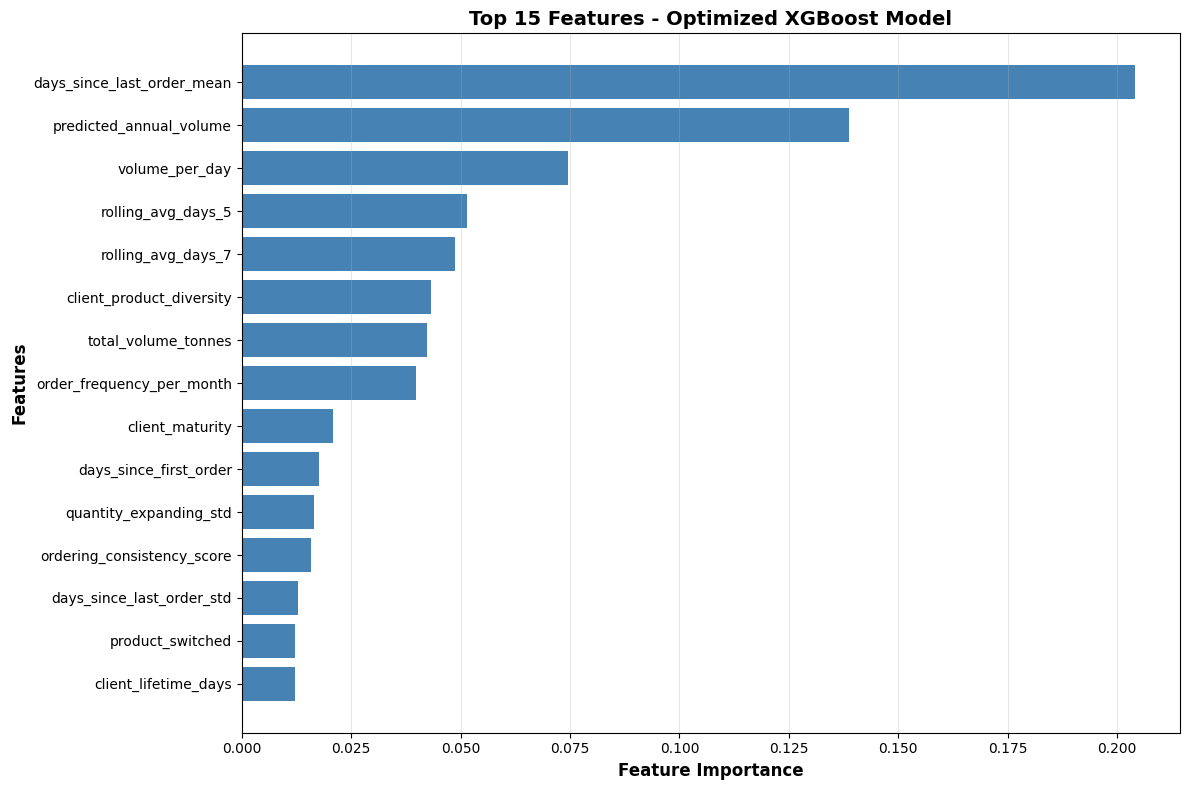


✅ Top 5 Features:
   1. days_since_last_order_mean                    - 0.2042
   2. predicted_annual_volume                       - 0.1386
   3. volume_per_day                                - 0.0746
   4. rolling_avg_days_5                            - 0.0514
   5. rolling_avg_days_7                            - 0.0486


In [22]:
print("="*80)
print("FEATURE IMPORTANCE ANALYSIS - OPTIMIZED MODEL")
print("="*80)

# Get feature importance
importance_df = pd.DataFrame({
    'feature': optimized_features,
    'importance': xgb_optimized.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top 20 Most Important Features:\n")
print(importance_df.head(20).to_string(index=False))

# Visualize top 15 features
plt.figure(figsize=(12, 8))
top_15 = importance_df.head(15)
plt.barh(range(len(top_15)), top_15['importance'], color='steelblue')
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('Top 15 Features - Optimized XGBoost Model', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✅ Top 5 Features:")
for i, row in importance_df.head(5).iterrows():
    print(f"   {list(importance_df.index).index(i)+1}. {row['feature']:45s} - {row['importance']:.4f}")

## Model Comparison Summary

In [23]:
print("\n" + "="*80)
print("FINAL SUMMARY & RECOMMENDATIONS")
print("="*80)

print("\n📊 MODEL COMPARISON:")
print(f"\n1️⃣ Original XGBoost (62 features):")
print(f"   • Test MAE: {original_test_mae:.2f} days")
print(f"   • Test R²: {original_test_r2:.4f}")
print(f"   • Includes: All features (clustering, full seasonality, etc.)")

print(f"\n2️⃣ Optimized XGBoost ({len(optimized_features)} features):")
print(f"   • Test MAE: {test_mae:.2f} days")
print(f"   • Test R²: {test_r2:.4f}")
print(f"   • Removed: Clustering (0% importance), low-value seasonality")
print(f"   • Focus: Client history, volume patterns, recent behavior")

print("\n💡 KEY INSIGHTS:")
print(f"   ✓ Feature reduction: {62} → {len(optimized_features)} features ({100*(62-len(optimized_features))/62:.1f}% reduction)")
print(f"   ✓ Performance change: {mae_diff:+.2f} days MAE, {r2_diff:+.4f} R²")
print(f"   ✓ Simpler model: Faster inference, easier maintenance")
print(f"   ✓ Focused features: High-importance features only")

print("\n🎯 RECOMMENDATION:")
if test_mae <= original_test_mae + 0.05:  # Within 0.05 days is acceptable
    print(f"   ✅ USE OPTIMIZED MODEL for production")
    print(f"      Reasons: Simpler, equivalent performance, easier to maintain")
else:
    print(f"   ⚠️  EVALUATE TRADE-OFF between simplicity and accuracy")
    print(f"      Consider: Is {abs(mae_diff):.2f} days worse worth {62-len(optimized_features)} fewer features?")

print("\n" + "="*80)


FINAL SUMMARY & RECOMMENDATIONS

📊 MODEL COMPARISON:

1️⃣ Original XGBoost (62 features):
   • Test MAE: 4.88 days
   • Test R²: 0.4823
   • Includes: All features (clustering, full seasonality, etc.)

2️⃣ Optimized XGBoost (47 features):
   • Test MAE: 6.14 days
   • Test R²: 0.5455
   • Removed: Clustering (0% importance), low-value seasonality
   • Focus: Client history, volume patterns, recent behavior

💡 KEY INSIGHTS:
   ✓ Feature reduction: 62 → 47 features (24.2% reduction)
   ✓ Performance change: -1.26 days MAE, +0.0632 R²
   ✓ Simpler model: Faster inference, easier maintenance
   ✓ Focused features: High-importance features only

🎯 RECOMMENDATION:
   ⚠️  EVALUATE TRADE-OFF between simplicity and accuracy
      Consider: Is 1.26 days worse worth 15 fewer features?



## Save Optimized Model

In [ ]:
import pickle

# Save model and scaler
model_path = r'C:\Users\Windows\Desktop\Dev_Projects\soya_excel\ml_training\xgboost_optimized_model.pkl'
scaler_path = r'C:\Users\Windows\Desktop\Dev_Projects\soya_excel\ml_training\xgboost_optimized_scaler.pkl'
features_path = r'C:\Users\Windows\Desktop\Dev_Projects\soya_excel\ml_training\xgboost_optimized_features.pkl'

with open(model_path, 'wb') as f:
    pickle.dump(xgb_optimized, f)

with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

with open(features_path, 'wb') as f:
    pickle.dump(optimized_features, f)

print("✅ Optimized model saved:")
print(f"   • Model: {model_path}")
print(f"   • Scaler: {scaler_path}")
print(f"   • Features: {features_path}")